<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/19_Ultra_pro_RNN_%D0%B8_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Макс 10 баллов

Загрузите тексты писателей по ссылке:

https://drive.google.com/file/d/1TeJxgfr2ZEY5Elil7XgM8WW7njI9Toqj/view?usp=sharing

Создайте обучающую, проверочную выборки.

Проведите серию экспериментов с различными подходами:

BoW

Embedding

LSTM

Conv1D

Сделайте вывод, какой подход дает максимально лучший результат



# Загрузка библиотек и данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files   # модуль для загрузки файлов в colab
import numpy as np               # библиотека для работы с массивами данных
import pandas as pd              # библиотека для обработки и анализа данных
import matplotlib.pyplot as plt  # библиотека для визуализации данных
import os                        # для работы с файловой системой
# для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils # модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential # последовательная модель нейросети кераса
# загружаем стандартные слои нейросети (полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence  # инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split                   # модуль для разбиения данных на обучающую и тестовую выборки

In [ ]:
def readText(fileName):          # объявляем функции для чтения файла, на вход отправляем путь к файлу
    f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
    text = f.read()                # читаем текст
    text = text.replace("\n", " ") # переносы строки переводим в пробелы

    return text                    # возвращаем текст файла

className = ['Беляев', 'Булгаков', 'Васильев', 'Гоголь', 'Гончаров', 'Горький', 'Грибоедов', 'Достоевский', 'Каверин', 'Катаев', 'Куприн', 'Лермонтов', 'Лесков', 'Носов', 'Пастернак', 'Пушкин', 'Толстой', 'Тургенев', 'Чехов', 'Шолохов'] # объявляем интересующие нас классы
nClasses = len(className)                                                         # считаем количество классов

In [ ]:
# загружаем обучающие тексты

Text = []  

for i in className:              # проходим по каждому классу
    for j in os.listdir('/content/drive/MyDrive/Colab Notebooks/Базы/texts_writers/'): # проходим по каждому файлу в папке с текстами
        if i in j:                   # проверяем, содержит ли файл j в названии имя класса i
            Text.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/texts_writers/' + j)) # добавляем в обучающую выборку
            print(j, 'добавлен в обучающую выборку') # выводим информацию

Беляев.txt добавлен в обучающую выборку
Булгаков.txt добавлен в обучающую выборку
Васильев.txt добавлен в обучающую выборку
Гоголь.txt добавлен в обучающую выборку
Гончаров.txt добавлен в обучающую выборку
Горький.txt добавлен в обучающую выборку
Грибоедов.txt добавлен в обучающую выборку
Достоевский.txt добавлен в обучающую выборку
Каверин.txt добавлен в обучающую выборку
Катаев.txt добавлен в обучающую выборку
Куприн.txt добавлен в обучающую выборку
Лермонтов.txt добавлен в обучающую выборку
Лесков.txt добавлен в обучающую выборку
Носов.txt добавлен в обучающую выборку
Пастернак.txt добавлен в обучающую выборку
Пушкин.txt добавлен в обучающую выборку
Толстой.txt добавлен в обучающую выборку
Тургенев.txt добавлен в обучающую выборку
Чехов.txt добавлен в обучающую выборку
Шолохов.txt добавлен в обучающую выборку


In [ ]:
print(len(Text))    # количество элементов в trainText
print(len(Text[1])) # количество символов в первом источнике в trainText

20
2001063


# Создание наборов данных

In [ ]:
#Получаем обучающую и тестовую выборки
def get_test_train(text):
    x_train=[]
    x_test =[]

    for i in range(len(text)):
        text_tr,text_test =train_test_split(text[i].split(),test_size=0.1, shuffle =True) # Делим текст на выборки
        x_train.append(' '.join(text_tr))      
        x_test.append(' '.join(text_test))      
    return x_train, x_test

x_train, x_test = get_test_train(Text)

In [ ]:
maxWordsCount = 20000 # определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(x_train)          # даём тексты в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # вытаскиваем индексы слов для просмотра

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train) # обучающие тексты в индексы
testWordIndexes = tokenizer.texts_to_sequences(x_test)   # проверочные тексты в индексы

In [ ]:
# формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # идём по всей длине вектора индексов
  # "откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

  
# формирование обучающей и проверочной выборки
# из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # для каждого из 6 классов создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):   # в диапазоне кол-ва классов (6)
    xT = classesXSamples[t]   # берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)):  # и каждое его окно
      xSamples.append(xT[i])  # добавляем в общий список выборки
    
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):  # на каждое окно выборки 
      ySamples.append(currY)  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку
  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# задаём базовые параметры
xLen = 1000 # длина отрезка текста, по которой анализируем, в словах
step = 100  # шаг разбиения исходного текста на обучающие вектора

In [ ]:
# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, 
# но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(77829, 1000)
(77829, 20)
(8481, 1000)
(8481, 20)


# Эксперименты

In [ ]:
def show_res():

  # Строим график для отображения динамики ошибки работы модели

  plt.figure(figsize = (14, 7))
  plt.plot(history.history['loss'], 
          label='Значение ошибки на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.show()

  # Строим график для отображения динамики обучения и точности предсказания сети
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

## Embedding

###Иссл.№1

Epoch 1/20
153/153 [==============================] - 58s 369ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 4.0210 - val_accuracy: 0.3429
Epoch 2/20
153/153 [==============================] - 56s 368ms/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 3.4930 - val_accuracy: 0.4244
Epoch 3/20
153/153 [==============================] - 56s 367ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 3.6085 - val_accuracy: 0.3787
Epoch 4/20
153/153 [==============================] - 56s 368ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 3.1652 - val_accuracy: 0.4434
Epoch 5/20
153/153 [==============================] - 56s 364ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 3.5511 - val_accuracy: 0.4290
Epoch 6/20
153/153 [==============================] - 56s 365ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 3.7994 - val_accuracy: 0.3895
Epoch 7/20
153/153 [==============================] - 56s 366ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 4.1420 - val_ac

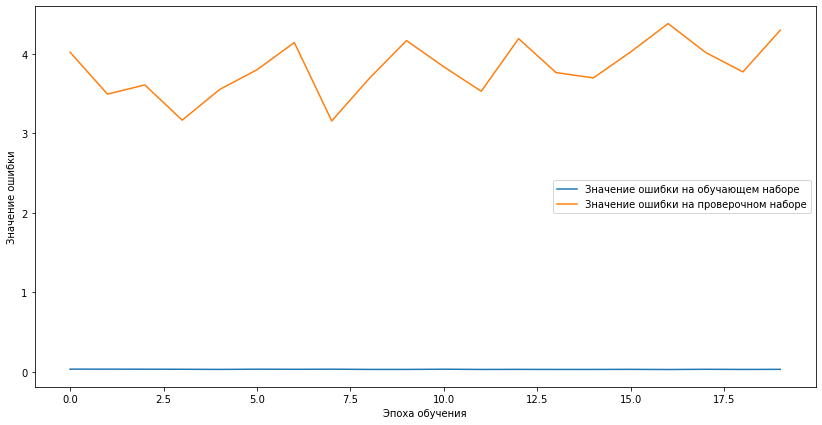

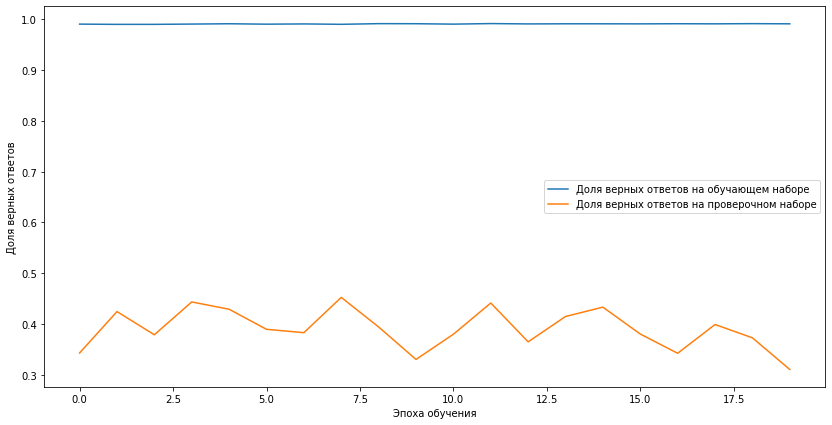

In [ ]:
model_ED_1 = Sequential()

model_ED_1.add(Embedding(maxWordsCount, 10, input_length = xLen))
model_ED_1.add(Dense(32, activation = 'relu'))
model_ED_1.add(SpatialDropout1D(0.4))
model_ED_1.add(Dense(64, activation = 'relu'))
model_ED_1.add(Flatten())
model_ED_1.add(Dense(20, activation='softmax'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelED.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelED.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики ошибки и точности обучения модели
show_res()


###Иссл.№2

Epoch 1/20
609/609 [==============================] - 65s 105ms/step - loss: 0.0888 - accuracy: 0.9722 - val_loss: 1.9725 - val_accuracy: 0.5543
Epoch 2/20
609/609 [==============================] - 64s 105ms/step - loss: 0.0810 - accuracy: 0.9745 - val_loss: 2.0029 - val_accuracy: 0.5500
Epoch 3/20
609/609 [==============================] - 65s 106ms/step - loss: 0.0773 - accuracy: 0.9756 - val_loss: 2.6478 - val_accuracy: 0.4411
Epoch 4/20
609/609 [==============================] - 64s 105ms/step - loss: 0.0732 - accuracy: 0.9766 - val_loss: 2.4189 - val_accuracy: 0.4691
Epoch 5/20
609/609 [==============================] - 63s 104ms/step - loss: 0.0737 - accuracy: 0.9764 - val_loss: 2.4014 - val_accuracy: 0.5230
Epoch 6/20
609/609 [==============================] - 63s 103ms/step - loss: 0.0733 - accuracy: 0.9775 - val_loss: 2.3286 - val_accuracy: 0.4989
Epoch 7/20
609/609 [==============================] - 63s 104ms/step - loss: 0.0701 - accuracy: 0.9778 - val_loss: 2.1231 - val_ac

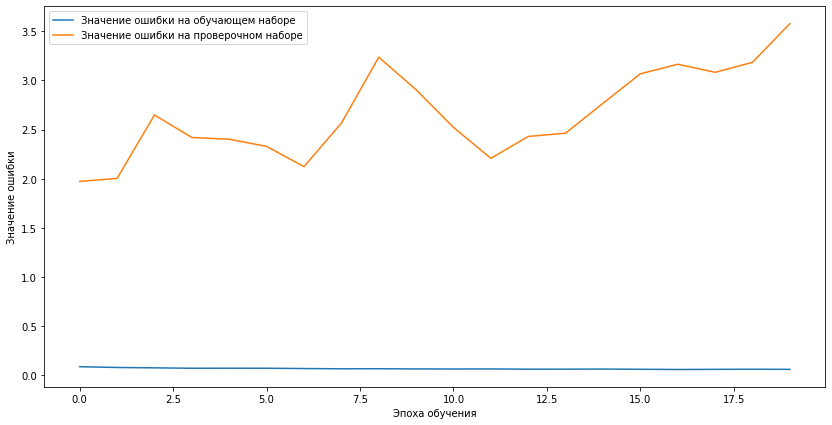

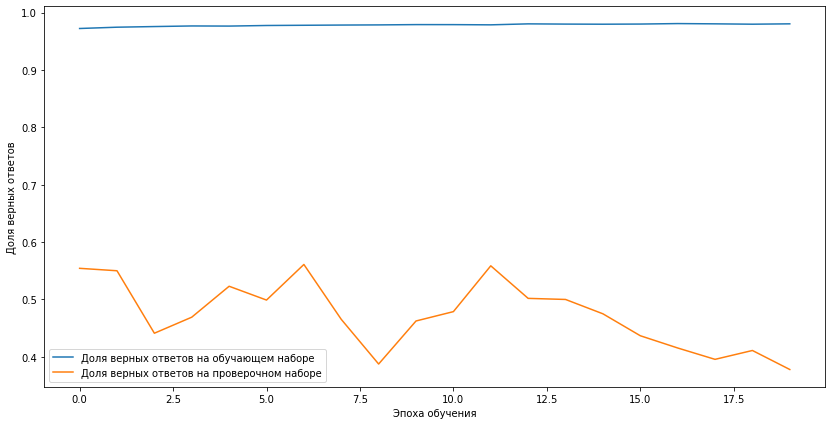

In [ ]:
model_ED_2 = Sequential()

model_ED_2.add(Embedding(maxWordsCount, 50, input_length = xLen))
model_ED_2.add(Dense(100, activation = 'relu'))
model_ED_2.add(SpatialDropout1D(0.5))
model_ED_2.add(Dense(100, activation = 'relu'))
model_ED_2.add(Flatten())
model_ED_2.add(Dense(20, activation='softmax'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelED.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelED.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики ошибки и точности обучения модели
show_res()

##LSTM

###Иссл.№3

Epoch 1/20
153/153 [==============================] - 158s 1s/step - loss: 1.2815 - accuracy: 0.6206 - val_loss: 0.2269 - val_accuracy: 0.9660
Epoch 2/20
153/153 [==============================] - 155s 1s/step - loss: 0.0574 - accuracy: 0.9954 - val_loss: 0.0136 - val_accuracy: 0.9991
Epoch 3/20
153/153 [==============================] - 151s 990ms/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 0.0049 - val_accuracy: 0.9993
Epoch 4/20
153/153 [==============================] - 151s 984ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/20
153/153 [==============================] - 152s 994ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 6/20
153/153 [==============================] - 154s 1s/step - loss: 8.5805e-04 - accuracy: 0.9998 - val_loss: 8.9932e-04 - val_accuracy: 1.0000
Epoch 7/20
153/153 [==============================] - 154s 1s/step - loss: 7.5529e-04 - accuracy: 0.9998 - val_loss: 0.0012 -

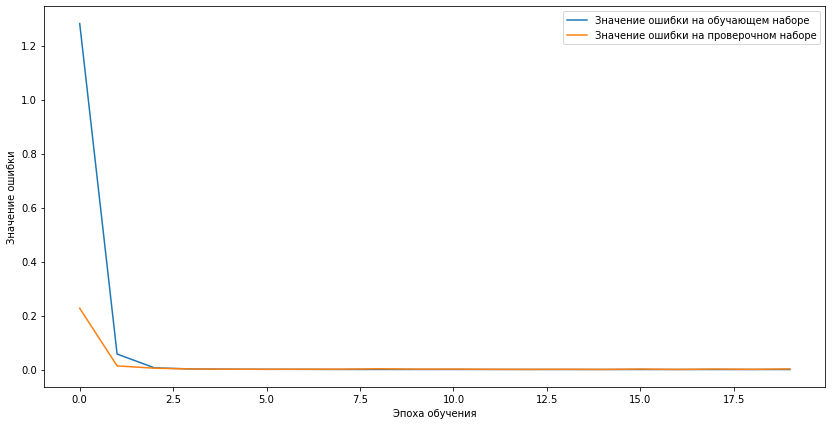

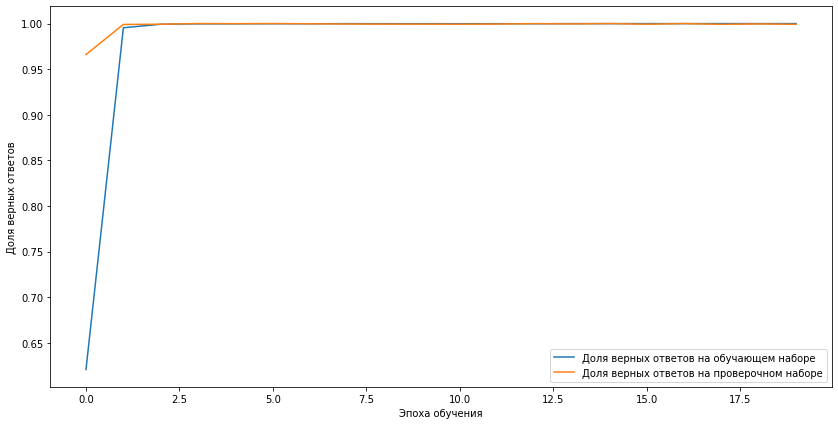

In [ ]:
model_L_1 = Sequential()

model_L_1.add(Embedding(maxWordsCount, 50, input_length = xLen))
model_L_1.add(SpatialDropout1D(0.4))
model_L_1.add(LSTM(4, return_sequences = True))
model_L_1.add(Flatten())
model_L_1.add(Dense(20, activation = 'softmax'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_L_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model_L_1.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики ошибки и точности обучения модели
show_res()

## Conv1D

###Иссл.№4

Epoch 1/10
153/153 [==============================] - 110s 710ms/step - loss: 2.0231 - accuracy: 0.3003 - val_loss: 1.8585 - val_accuracy: 0.3838
Epoch 2/10
153/153 [==============================] - 108s 707ms/step - loss: 0.7192 - accuracy: 0.7516 - val_loss: 0.4709 - val_accuracy: 0.8210
Epoch 3/10
153/153 [==============================] - 109s 710ms/step - loss: 0.2014 - accuracy: 0.9436 - val_loss: 0.1876 - val_accuracy: 0.9364
Epoch 4/10
153/153 [==============================] - 109s 710ms/step - loss: 0.0778 - accuracy: 0.9792 - val_loss: 0.2848 - val_accuracy: 0.9030
Epoch 5/10
153/153 [==============================] - 107s 702ms/step - loss: 0.0622 - accuracy: 0.9834 - val_loss: 0.6135 - val_accuracy: 0.8176
Epoch 6/10
153/153 [==============================] - 107s 700ms/step - loss: 0.0487 - accuracy: 0.9870 - val_loss: 0.6336 - val_accuracy: 0.8262
Epoch 7/10
153/153 [==============================] - 108s 705ms/step - loss: 0.0295 - accuracy: 0.9923 - val_loss: 0.4275 -

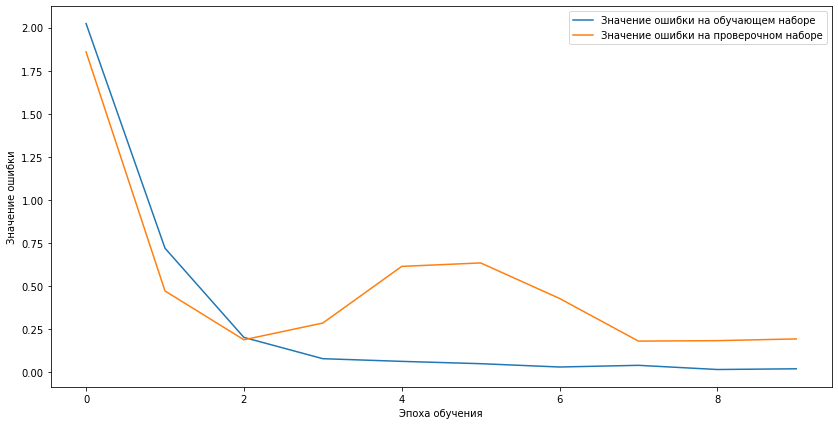

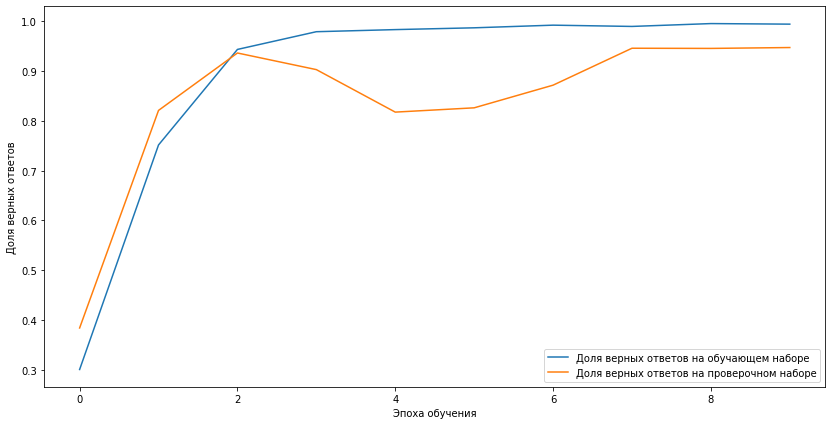

In [ ]:
model_C_1 = Sequential()

model_C_1.add(Embedding(maxWordsCount, 50, input_length = xLen))
model_C_1.add(SpatialDropout1D(0.4))
model_C_1.add(Conv1D(10, 5, padding = 'same', activation = 'relu'))
model_C_1.add(Conv1D(20, 5, padding = 'same', activation = 'relu'))
model_C_1.add(Flatten())
model_C_1.add(Dense(20, activation= 'softmax'))

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_C_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model_C_1.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики ошибки и точности обучения модели
show_res()

##BOW

###Иссл.№5

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())


Epoch 1/10
609/609 [==============================] - 13s 19ms/step - loss: 0.1684 - accuracy: 0.9725 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/10
609/609 [==============================] - 11s 18ms/step - loss: 0.0120 - accuracy: 0.9990 - val_loss: 1.6287e-04 - val_accuracy: 1.0000
Epoch 3/10
609/609 [==============================] - 11s 18ms/step - loss: 0.0049 - accuracy: 0.9996 - val_loss: 6.5868e-05 - val_accuracy: 1.0000
Epoch 4/10
609/609 [==============================] - 11s 18ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 8.3185e-05 - val_accuracy: 1.0000
Epoch 5/10
609/609 [==============================] - 11s 18ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.2969e-05 - val_accuracy: 1.0000
Epoch 6/10
609/609 [==============================] - 11s 19ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 8.7957e-06 - val_accuracy: 1.0000
Epoch 7/10
609/609 [==============================] - 11s 18ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 1.

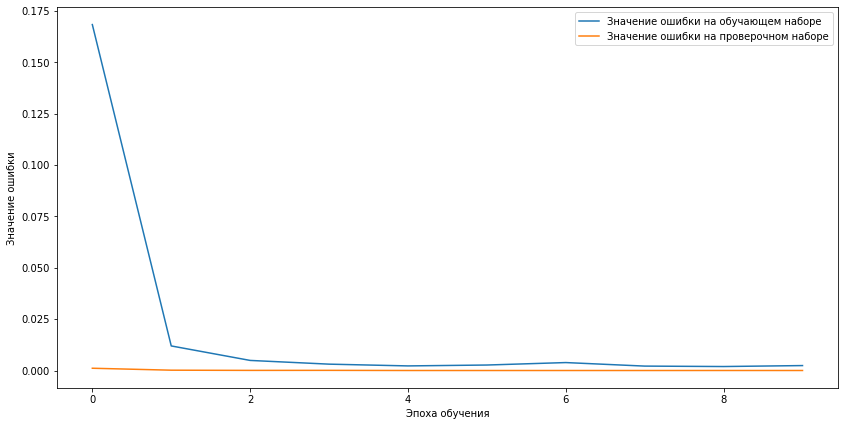

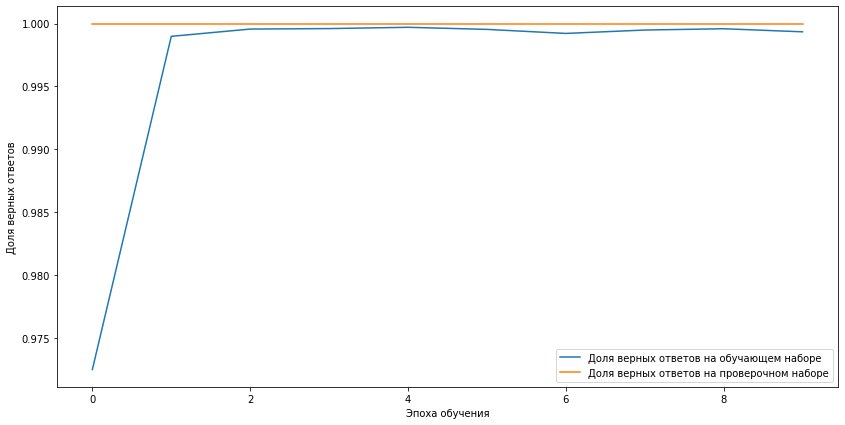

In [ ]:
#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

# model.add(Dense(32, activation="relu"))
# #Слой регуляризации Dropout
# model.add(Dropout(0.25))
# model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(20, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

# Строим график для отображения динамики ошибки и точности обучения модели
show_res()

##Embadding + Dense + Conv1D

###Иссл.№6 (необязательное)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1217/1217 [==============================] - 76s 62ms/step - loss: 3.0681 - accuracy: 0.0901 - val_loss: 2.6692 - val_accuracy: 0.2140
Epoch 2/20
1217/1217 [==============================] - 74s 61ms/step - loss: 2.3116 - accuracy: 0.2758 - val_loss: 2.1644 - val_accuracy: 0.3677
Epoch 3/20
1217/1217 [==============================] - 73s 60ms/step - loss: 1.7145 - accuracy: 0.4777 - val_loss: 1.6997 - val_accuracy: 0.5311
Epoch 4/20
1217/1217 [==============================] - 73s 60ms/step - loss: 1.2592 - accuracy: 0.6504 - val_loss: 1.3007 - val_accuracy: 0.7037
Epoch 5/20
1217/1217 [==============================] - 73s 60ms/step - loss: 0.9221 - accuracy: 0.7648 - val_loss: 1.0909 - val_accuracy: 0.7598
Epoch 6/20
1217/1217 [==============================] - 72s 60ms/step - loss: 0.7135 - accuracy: 0.8229 - val_loss: 1.0524 - val_accuracy: 0.7353
Epoch 7/20
1217/1217 [==============================] - 73s 60ms/step - loss: 0.5724 - accuracy: 0.8565 - val_loss: 0.9663 -

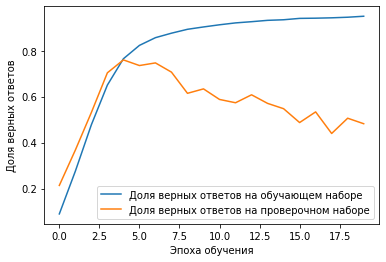

In [ ]:
modelED = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelED.add(Embedding(maxWordsCount, 10, input_length=xLen))
modelED.add(Conv1D(10, 5, padding='same', activation='relu')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelED.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelED.add(Flatten())
modelED.add(BatchNormalization())  # добавляем слой нормализации данных
modelED.add(Dense(32, activation="relu"))  # добавляем полносвязный слой
modelED.add(Dropout(0.2))
modelED.add(BatchNormalization())
modelED.add(Dense(20, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelED.compile(optimizer=RMSprop(lr=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelED.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Выводы

Хуже всего отработала сложная нейросеть , ее не было в условиях задачи, дополнительное исследование. Метод BOW дал сразу высокий результат точности, это самый быстрый и точный метод применительно к данной задаче. 
  Embedding в чистом виде дает плохой результат.
  Embedding + LSTM / Embedding + Сonv1D дали высокую точность , но временные затраты больше, чем в методе BOW.